In [1]:
from py_sc_fermi.defect_charge_state import DefectChargeState, FrozenDefectChargeState
from py_sc_fermi.defect_system import DefectSystem
from py_sc_fermi.defect_species import DefectSpecies
from py_sc_fermi.inputs import inputs_from_files, read_input_data
from itertools import product
from tqdm import tqdm
from scipy.constants import physical_constants
from pandas import DataFrame as df
import numpy as np
import sc_pyper_functions as scpf
import pandas as pd
import auto_functions as af
import matplotlib.pyplot as plt
import yaml

with open('automator_config.yaml', 'r') as stream: # get defect information from .yaml config
    try:                                           
        defect_params = yaml.safe_load(stream)     # return as a dict called defect_params
    except yaml.YAMLError as exc:
        print(exc)                                

defects = af.import_calculations_from_file('defects.yaml')         # read in raw vasp data as vasppy calculation objects.
elements = af.import_calculations_from_file('elements.yaml')       # and give them intuitive names
llzo = af.import_calculations_from_file('interest.yaml')           #
ex_grid = (pd.read_csv('ex_grid.dat', skiprows=10, sep='\s+'))     # read in chemical potential grids as outputted by cplap 
grid = (pd.read_csv('grid.dat', skiprows=10, sep='\s+'))           # with both a larger grid and a smaller grid

def make_all_defects(config_dict,chem_pots):
    """
    Take defect data and return py_sc_fermi friendly defect objects.
    """
    defs = []
    for k,v in config_dict['defects'].items():
        label = [i for i in config_dict['defects'][k][1:]]
        to_calcs = [defects[i] for i in label]
        out = af.make_defect(to_calcs, elements, llzo['LLZO'], delta_mu=chem_pots, corr=config_dict['iccs'], sites=1)
        out._nsites = config_dict['defects'][out.name][0]
        defs.append(out)
    return defs

def wrap_concs(results):
    v_li = (results['v_Li_-1.0'] + results['v_Li_0.0'])
    i_li = (results['Li_i_1.0'] + results['Li_i_0.0'])
    v_la = (results['v_La_-3.0'])
    v_zr = (results['v_Zr_-4.0'])
    v_o = (results['v_O_0.0']+results['v_O_1.0']+results['v_O_2.0'])
    o_i = (results['O_i_0.0']+results['O_i_-1.0'])
    zr_li = (results['Zr_Li_0.0'] + results['Zr_Li_1.0']+results['Zr_Li_2.0']+results['Zr_Li_3.0'])
    zr_li_t = ( results['Zr_Li_tet_0.0'] + results['Zr_Li_tet_1.0']+results['Zr_Li_tet_2.0']+results['Zr_Li_tet_3.0'])
    zr_i = (results['Zr_i_0.0'] + results['Zr_i_1.0'] + results['Zr_i_2.0'] + results['Zr_i_3.0'] + results['Zr_i_4.0'])
    la_zr = (results['La_Zr_0.0'] + results['La_Zr_-1.0'])
    zr_la = (results['Zr_La_0.0'] + results['Zr_La_1.0'])
    li_zr = ( results['Li_Zr_0.0'] + results['Li_Zr_-1.0']+results['Li_Zr_-2.0']+results['Li_Zr_-3.0'])
    li_la = ( results['Li_La_0.0'] + results['Li_La_-1.0']+results['Li_La_-2.0'])
    la_li = ( results['La_Li_0.0'] + results['La_Li_1.0']+results['La_Li_2.0'])
    return {'v_Li':v_li,'Li_i':i_li,'v_La':v_la,'v_Zr':v_zr,'v_O':v_o,'O_i':o_i,'Zr_Li':zr_li,'Zr_Li_tet':zr_li_t,'Zr_i':zr_i,'La_Zr':la_zr,'Li_Zr':li_zr,'Li_La':li_la,'La_Li':la_li,'Zr_La':zr_la}

grid_to_test = 80

unitcell_filename = 'unitcell.dat' # Read structure
totdos_filename = 'totdos.dat'     # read totdos.dat
input_fermi_filename = 'input_fermi_cont.dat' # read default calculation params
compilied_defects = make_all_defects(defect_params,grid.iloc[grid_to_test])
inputs = inputs_from_files(unitcell_filename=unitcell_filename, 
                                   input_fermi_filename=input_fermi_filename, 
                                   totdos_filename=totdos_filename, frozen=False)
print(compilied_defects)

Volume of cell: 1056.622886347127 A^3
Found spin polarised system...
Number of electrons in system: 544
Energy gap of system: 5.904 eV
Temperature: 1500.0 K
Number of defect species: 14
Reading spin-polarised DOS
[
v_O, nsites=3
  q=+2, e=-6.522686024237847, deg=1
  q=+1, e=-2.9798363610594905, deg=2
  q=+0, e=1.4309776500000648, deg=1
, 
v_Li, nsites=3
  q=+0, e=4.57135738000001, deg=2
  q=-1, e=5.059671988940584, deg=1
, 
Li_i, nsites=1
  q=+0, e=1.5462461100000686, deg=2
  q=+1, e=-4.039530639755103, deg=1
, 
O_i, nsites=1
  q=+0, e=6.808925799999978, deg=1
  q=-1, e=12.515873548940514, deg=1
, 
v_La, nsites=2
  q=-3, e=16.170599598259024, deg=1
, 
v_Zr, nsites=1
  q=-4, e=22.10056016913296, deg=1
, 
Zr_i, nsites=1
  q=+0, e=6.495774575000063, deg=1
  q=+1, e=1.4894299339405968, deg=1
  q=+2, e=-5.00699208807507, deg=1
  q=+3, e=-9.585246264535193, deg=2
  q=+4, e=-13.88328844195141, deg=1
, 
Zr_Li_tet, nsites=1
  q=+0, e=4.413391605000051, deg=8
  q=+1, e=-0.5280526648234792, deg=4

100%|██████████| 83/83 [00:08<00:00, 10.21it/s]


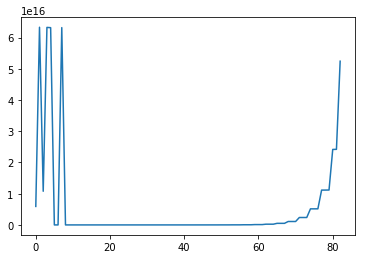

In [3]:
from tqdm import tqdm
from collections import defaultdict
import re
import subprocess
class chg_car_SCFermi:
    """
    SCFermi class containing all information needed to carry out an SC-Fermi calculationm including defects, number of eletrons, band gap magnitude, temperature, and whether the DFT calculation was spin polarised 
    currently only allows consideration of one 'dopant'
    """

    def __init__( self, defects, nelect, e_gap, temperature, dopants=None, fixed_defects=None, spin_polarised=False):
        self.defects = defects
        self.fixed_defects = fixed_defects
        self.nelect = nelect
        self.e_gap = e_gap
        self.temperature = temperature
        self.spin_polarised = spin_polarised
        self.dopants = dopants

    @property
    def n_defects( self ):
        return len( self.defects )
    
    @property
    def n_fixed_defects( self ):
        return len( self.fixed_defects )

    def output( self ):
            with open('input-fermi-frozen.dat', 'w') as f:
                if self.spin_polarised:
                    f.write( '2' + '\n')
                else:
                    f.write( '1' + '\n' )
                f.write( str(self.nelect) + '\n' )
                f.write( str(self.e_gap) + '\n')
                f.write( str(self.temperature) + '\n')
                f.write( str(self.n_defects) + '\n' )
                for d in self.defects:
                    f.write( '{} {} {}'.format( d.label, d.n_charge_states, d.n_sites ) + '\n')
                    for c in d.charge_states:
                        f.write( '{} {} {}'.format( c.charge, c.formation_energy, c.degeneracy ) + '\n')
                
                if self.fixed_defects is not None:
                    f.write( str(self.n_fixed_defects) + '\n' )
                    for k,v in self.fixed_defects.items():
                        f.write( '{} {}'.format( k, v ) + '\n')
                else:
                    f.write('0' + '\n')
                if self.dopants is not None:
                    f.write( '1' + '\n')
                    for k,v in self.dopants.items():
                        f.write( 'Dopant ' + '{} {}'.format( k, v ) + '\n')
                else:
                    f.write('0')
            f.close()
            
    
def run_some_chg_car_fermi(defects, nelect, e_gap, temperature, dopants=None, fixed_defects=None, spin_polarised=False):
    """
    a function to run a frozen SCFermi calculation, and retun the concentrations of all the relevent defects. 
    args:
        defects (list): a list of defects to be considered as part of this calculation
        T (float): the temperature (in Kelvin) the concentrations are to be calculated at
        e_gap (float): magnitude of bandgap
        spin_polarised (bool): whether the DFT data is spin polarised
        dopant_chg (int): charge on the frozen defect
        dopant_conc (int): concentration of the frozen defect in n/cm-3
    returns:
        flat (dict): a dictionary specifiying defect concentrations.
        
        Note: function currently assumes executable frozen sc-fermi in directory.
    """
    out = []
    scf = chg_car_SCFermi(defects, nelect, e_gap, temperature, dopants, fixed_defects, spin_polarised=False)
    scf.output()
    with open("out.txt", 'w') as f:
        sp = subprocess.run(["./frozen-sc-fermi"],stdout=f)
        text_file = open(("out.txt") , "r")
        lines =  text_file.readlines()
        for i in defects:
                for line in lines:
                    if re.search(str(i.label)+' '+r'.*?Charge',line) is not None:
                        for h in range(i.n_charge_states):
                            joop = lines[lines.index(line)+(h+1)]
                            coop = joop.split()
                            x = coop[1]
                            y = float(coop[-2])
                            a_dict = {(i.label)+'_'+str(x) : y}
                            out.append(a_dict)
                            flat = {k: v for d in out for k, v in d.items()}
        for line in lines:
            if re.search('\(electrons\)', line) is not None:
                flat.update({'c_e' : float(line.split()[3])})
            if re.search('\(holes\)', line) is not None:
                flat.update({'c_h' : float(line.split()[3])})
            if re.search('\(eV\)', line) is not None:
                flat.update({'Fermi_level' : float(line.split()[4])})
            if re.search('Dopant\ \ \ \ \ \ \ \ \ :', line) is not None:
                flat.update({'Dopant' : float(line.split()[2])})
        return flat
    
class SYFermi:
    """
    SCFermi class containing all information needed to carry out an SC-Fermi calculationm including defects, number of eletrons, band gap magnitude, temperature, and whether the DFT calculation was spin polarised 
    currently only allows consideration of one 'dopant'
    """

    def __init__( self, defects, nelect, e_gap, temperature, fixed_charge_states=None, fixed_defects=None, spin_polarised=False):
        self.defects = defects
        self.fixed_defects = fixed_defects
        self.fixed_charge_states = fixed_charge_states
        self.nelect = nelect
        self.e_gap = e_gap
        self.temperature = temperature
        self.spin_polarised = spin_polarised

    @property
    def n_defects( self ):
        return len( self.defects )
    
    @property
    def n_fixed_defects( self ):
        return len( self.fixed_defects )
    
    @property
    def n_fixed_charge_states( self ):
        return len( self.fixed_charge_states )

    def output( self ):
            with open('input-fermi-frozen.dat', 'w') as f:
                if self.spin_polarised:
                    f.write( '2' + '\n')
                else:
                    f.write( '1' + '\n' )
                f.write( str(self.nelect) + '\n' )
                f.write( str(self.e_gap) + '\n')
                f.write( str(self.temperature) + '\n')
                f.write( str(self.n_defects) + '\n' )
                for d in self.defects:
                    f.write( '{} {} {}'.format( d.label, d.n_charge_states, d.n_sites ) + '\n')
                    for c in d.charge_states:
                        f.write( '{} {} {}'.format( c.charge, c.formation_energy, c.degeneracy ) + '\n')
                
                if self.fixed_defects is not None:
                    f.write( str(self.n_fixed_defects) + '\n' )
                    for k,v in self.fixed_defects.items():
                        f.write( '{} {}'.format( k, v ) + '\n')
                else:
                    f.write('0' + '\n')
                    
                if self.fixed_charge_states is not None:
                    f.write( str(self.n_fixed_charge_states) + '\n')
                    for i in self.fixed_charge_states:
                        i = i[0].split(' ')
                        f.write( '{} {} {}'.format( i[0], i[1], i[2] ) + '\n')
                else:
                    f.write('0')
            f.close()
            
    
def run_some_chg_car_fermi(defects, nelect, e_gap, temperature, dopants=None, fixed_defects=None, spin_polarised=False):
    """
    a function to run a frozen SCFermi calculation, and retun the concentrations of all the relevent defects. 
    args:
        defects (list): a list of defects to be considered as part of this calculation
        T (float): the temperature (in Kelvin) the concentrations are to be calculated at
        e_gap (float): magnitude of bandgap
        spin_polarised (bool): whether the DFT data is spin polarised
        dopant_chg (int): charge on the frozen defect
        dopant_conc (int): concentration of the frozen defect in n/cm-3
    returns:
        flat (dict): a dictionary specifiying defect concentrations.
        
        Note: function currently assumes executable frozen sc-fermi in directory.
    """
    out = []
    scf = chg_car_SCFermi(defects, nelect, e_gap, temperature, dopants, fixed_defects, spin_polarised=False)
    scf.output()
    with open("out.txt", 'w') as f:
        sp = subprocess.run(["./frozen-sc-fermi"],stdout=f)
        text_file = open(("out.txt") , "r")
        lines =  text_file.readlines()
        for i in defects:
                for line in lines:
                    if re.search(str(i.label)+' '+r'.*?Charge',line) is not None:
                        for h in range(i.n_charge_states):
                            joop = lines[lines.index(line)+(h+1)]
                            coop = joop.split()
                            x = coop[1]
                            y = float(coop[-2])
                            a_dict = {(i.label)+'_'+str(x) : y}
                            out.append(a_dict)
                            flat = {k: v for d in out for k, v in d.items()}
        for line in lines:
            if re.search('\(electrons\)', line) is not None:
                flat.update({'c_e' : float(line.split()[3])})
            if re.search('\(holes\)', line) is not None:
                flat.update({'c_h' : float(line.split()[3])})
            if re.search('\(eV\)', line) is not None:
                flat.update({'Fermi_level' : float(line.split()[4])})
            if re.search('Dopant\ \ \ \ \ \ \ \ \ :', line) is not None:
                flat.update({'Dopant' : float(line.split()[2])})
        return flat
    
    
def run_some_SY_fermi(defects, nelect, e_gap, temperature, fixed_charge_states=None, fixed_defects=None, spin_polarised=False):
    """
    a function to run a frozen SCFermi calculation, and retun the concentrations of all the relevent defects. 
    args:
        defects (list): a list of defects to be considered as part of this calculation
        T (float): the temperature (in Kelvin) the concentrations are to be calculated at
        e_gap (float): magnitude of bandgap
        spin_polarised (bool): whether the DFT data is spin polarised
        dopant_chg (int): charge on the frozen defect
        dopant_conc (int): concentration of the frozen defect in n/cm-3
    returns:
        flat (dict): a dictionary specifiying defect concentrations.
        
        Note: function currently assumes executable frozen sc-fermi in directory.
    """
    out = []
    scf = SYFermi(defects, nelect, e_gap, temperature,  fixed_charge_states, fixed_defects, spin_polarised=True)
    scf.output()
    with open("out.txt", 'w') as f:
        sp = subprocess.run(["./frozen-sc-fermi"],stdout=f)
        text_file = open(("out.txt") , "r")
        lines =  text_file.readlines()
        for i in defects:
                for line in lines:
                    if re.search(str(i.label)+' '+r'.*?Charge',line) is not None:
                        for h in range(i.n_charge_states):
                            joop = lines[lines.index(line)+(h+1)]
                            coop = joop.split()
                            x = coop[1]
                            y = float(coop[-2])
                            a_dict = {(i.label)+'_'+str(x) : y}
                            out.append(a_dict)
                            flat = {k: v for d in out for k, v in d.items()}
        for line in lines:
            if re.search('\(electrons\)', line) is not None:
                flat.update({'c_e' : float(line.split()[3])})
            if re.search('\(holes\)', line) is not None:
                flat.update({'c_h' : float(line.split()[3])})
            if re.search('\(eV\)', line) is not None:
                flat.update({'Fermi_level' : float(line.split()[4])})
            if re.search('Dopant\ \ \ \ \ \ \ \ \ :', line) is not None:
                flat.update({'Dopant' : float(line.split()[2])})
        return flat

itscrazybutitmightjustwork = []        
for i in tqdm(range(len(grid))): 
    a = scpf.make_defect([defects['v_O'],defects['v_O_+'],defects['v_O_++']], elements, llzo['LLZO'], delta_mu=grid.iloc[i].to_dict(), corr=defect_params['iccs'], sites=3 )
    b = scpf.make_defect([defects['Li_i'],defects['Li_i_+']], elements, llzo['LLZO'], delta_mu=grid.iloc[i].to_dict(), corr=defect_params['iccs'] )
    c = scpf.make_defect([defects['v_Li'],defects['v_Li_-']], elements, llzo['LLZO'], delta_mu=grid.iloc[i].to_dict(), corr=defect_params['iccs'], sites=3 )
    d = scpf.make_defect([defects['v_La_---']], elements, llzo['LLZO'], delta_mu=grid.iloc[i].to_dict(), corr=defect_params['iccs'], sites=2 )
    e = scpf.make_defect([defects['v_Zr_----']], elements, llzo['LLZO'], delta_mu=grid.iloc[i].to_dict(), corr=defect_params['iccs'] )
    f = scpf.make_defect([defects['Zr_La'],defects['Zr_La_+']], elements, llzo['LLZO'], delta_mu=grid.iloc[i].to_dict() , corr=defect_params['iccs'], sites=2)
    g = scpf.make_defect([defects['La_Zr_-'],defects['La_Zr']], elements, llzo['LLZO'], delta_mu=grid.iloc[i].to_dict(), corr=defect_params['iccs'])
    h = scpf.make_defect([defects['Zr_Li'],defects['Zr_Li_+'],defects['Zr_Li_++'],defects['Zr_Li_+++']], elements, llzo['LLZO'], delta_mu=grid.iloc[i].to_dict(), corr=defect_params['iccs'],sites=2 )
    j = scpf.make_defect([defects['O_i'],defects['O_i_-']], elements, llzo['LLZO'], delta_mu=grid.iloc[i].to_dict() , corr=defect_params['iccs'])
    p = scpf.make_defect([defects['Zr_Li_tet'],defects['Zr_Li_tet_+'],defects['Zr_Li_tet_++'],defects['Zr_Li_tet_+++']], elements, llzo['LLZO'], delta_mu=grid.iloc[i].to_dict(), corr=defect_params['iccs'] )
    q = scpf.make_defect([defects['Zr_i'],defects['Zr_i_+'],defects['Zr_i_++'],defects['Zr_i_+++'],defects['Zr_i_++++']], elements, llzo['LLZO'], delta_mu=grid.iloc[i].to_dict(), corr=defect_params['iccs'] )
    results = scpf.run_some_fermi([a,b,c,d,e,f,g,h,j,p,q],nelect=544, e_gap=5.9034, T=1500, spin_polarised=True)
#     for_frozen = {k : v for k,v in results.items() if k is not 'Fermi_level' and k is not 'c_e' and k is not 'c_h'}
#     formatt = [(str(k.split('_')[:-1]), v) for k,v in for_frozen.items()]
#     z = defaultdict(list) 
#     for k, v in formatt:
#         z[k].append(v)
#     gg = {k:sum(v) for k,v in z.items()}
#     regex = re.compile('[^a-zA-Z,]')
#     x = {regex.sub('', k):v for k,v in gg.items()}
#     regex = re.compile('[^a-zA-Z]')
#     y = {regex.sub('_', k):v for k,v in x.items()}
#     please = run_some_chg_car_fermi([a,b,c,d,e,f,g,h,j,p,q],nelect=544, e_gap=5.9034, temperature=1000, spin_polarised=True, fixed_defects=y)
    itscrazybutitmightjustwork.append(results['c_e'])      
   # print(itscrazybutitmightjustwork)
plt.plot(itscrazybutitmightjustwork)

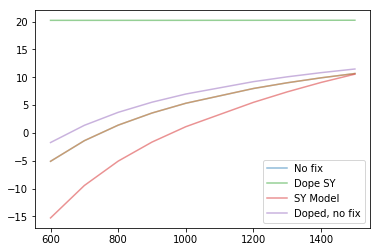

TD


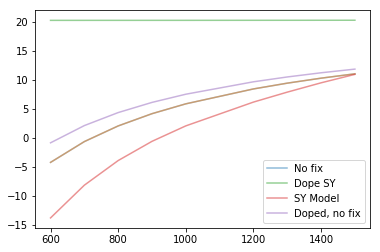

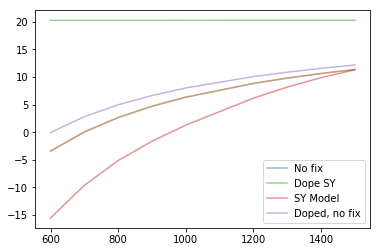

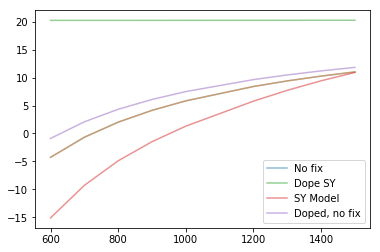

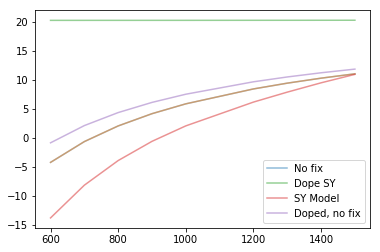

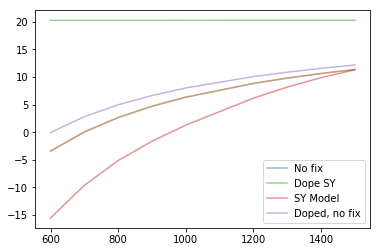

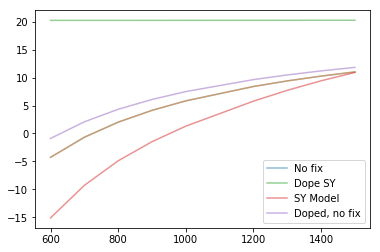

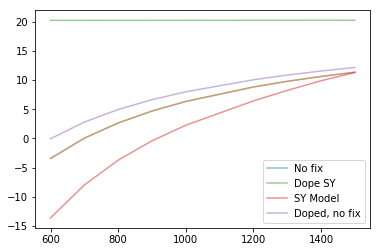

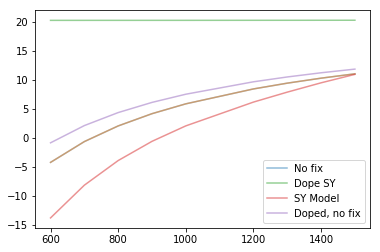

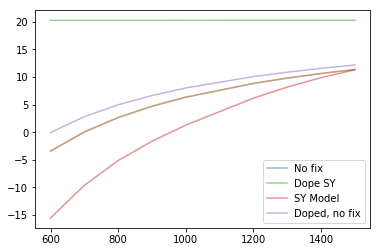

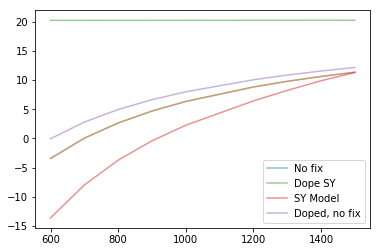

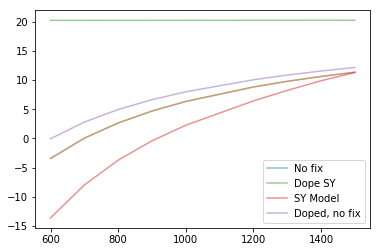

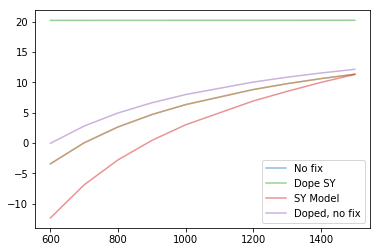

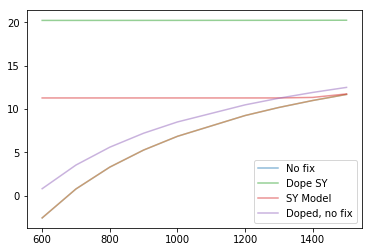

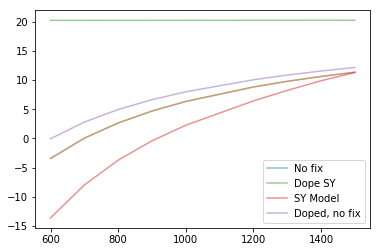

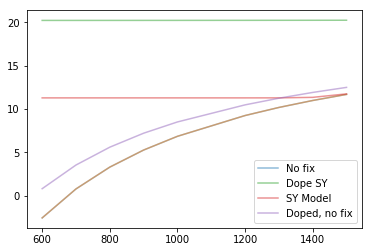

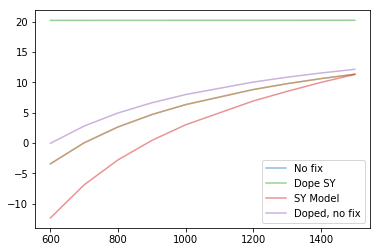

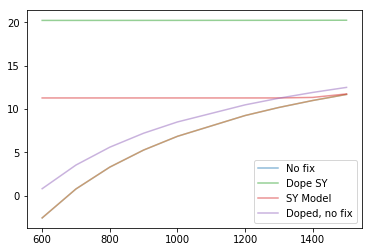

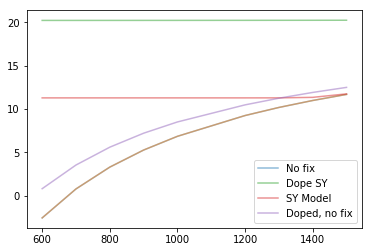

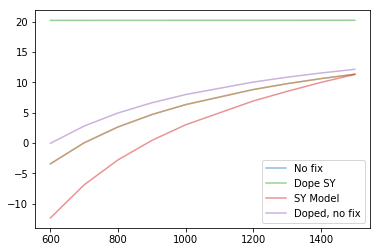

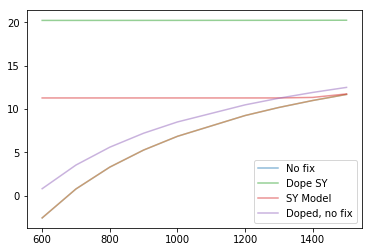

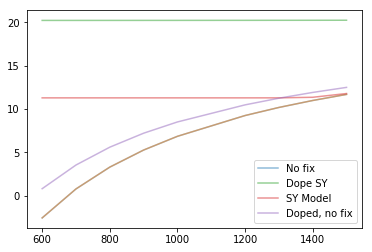

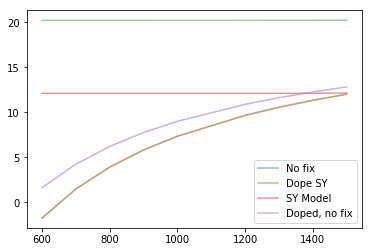

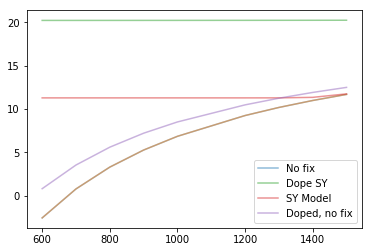

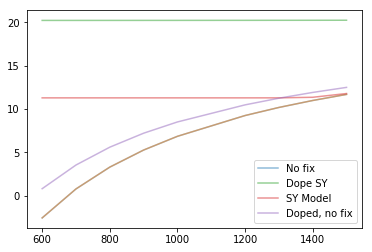

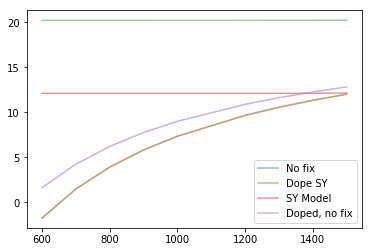

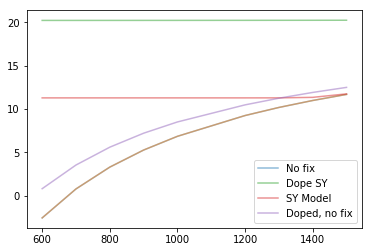

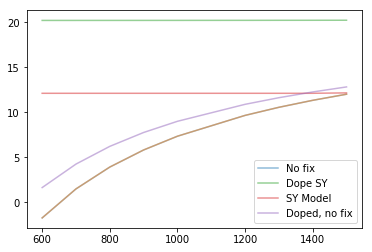

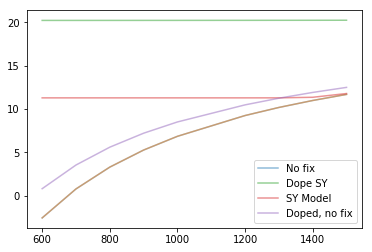

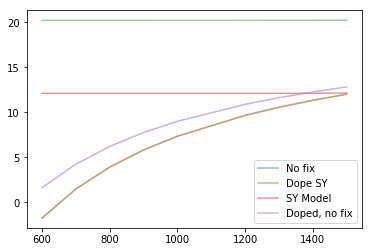

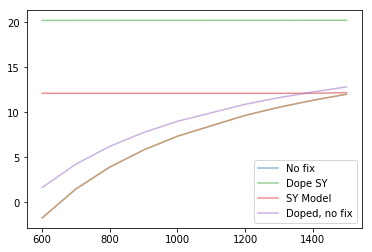

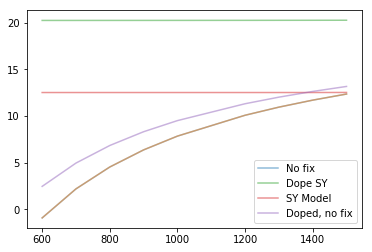

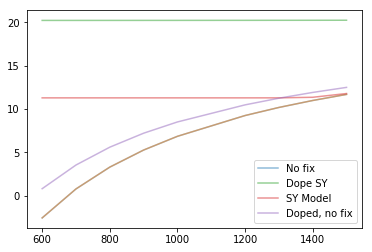

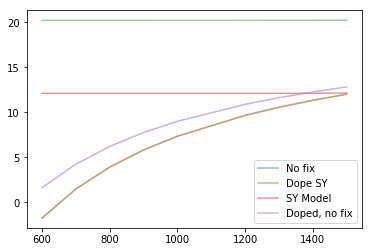

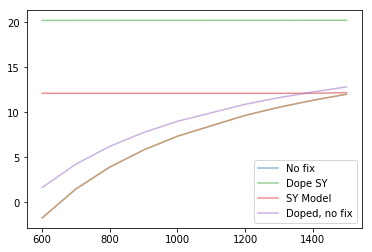

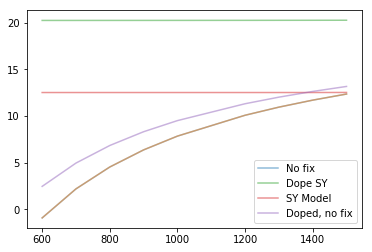

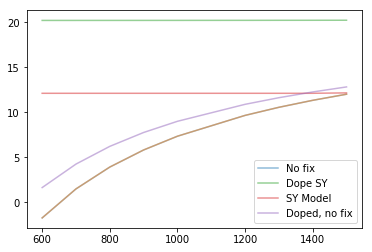

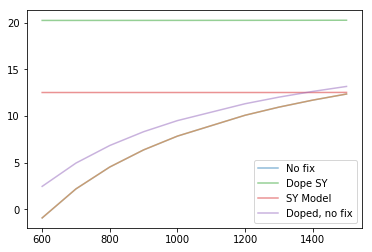

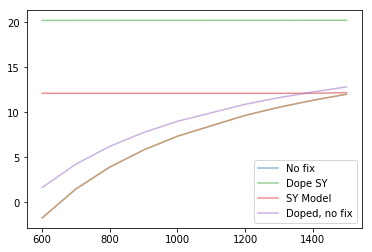

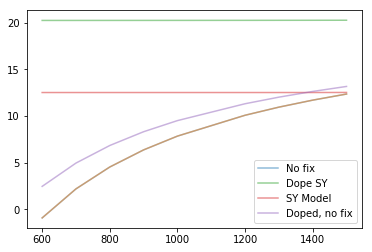

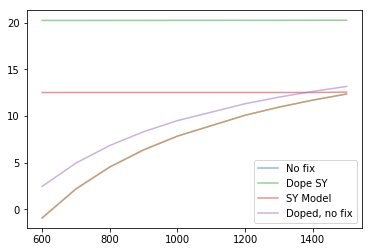

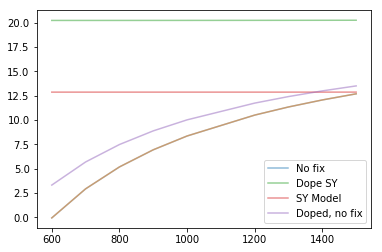

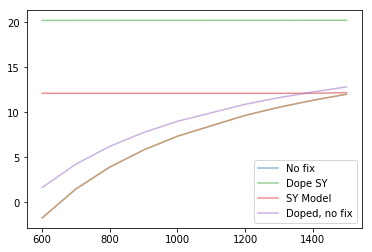

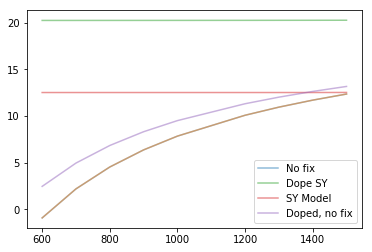

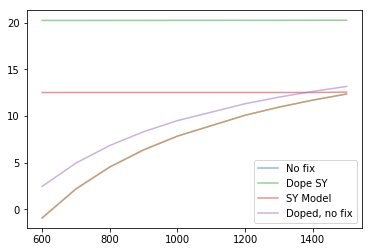

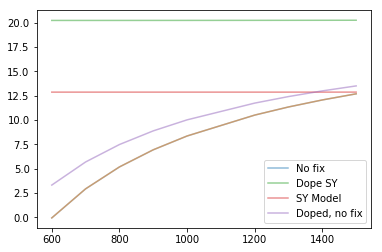

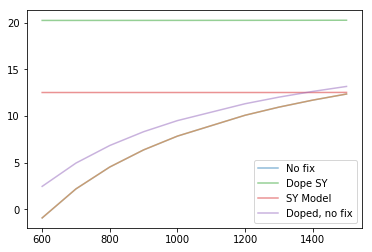

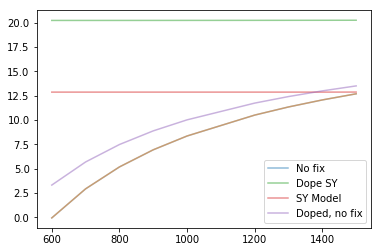

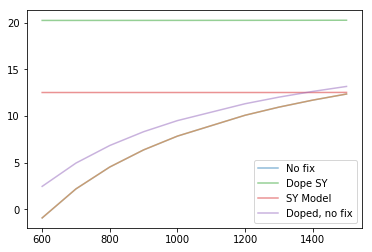

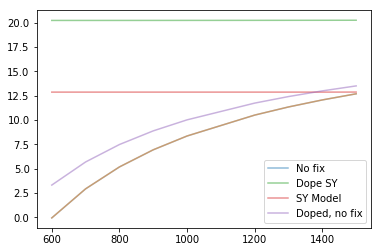

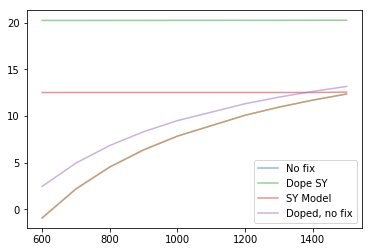

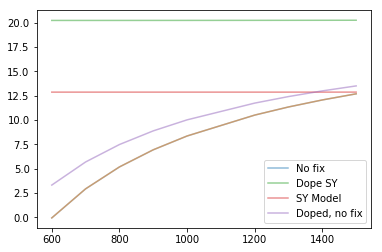

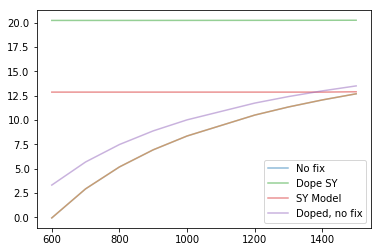

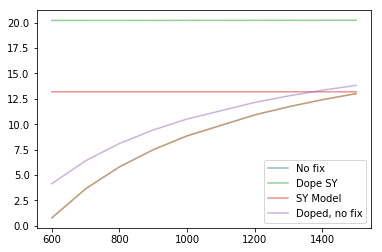

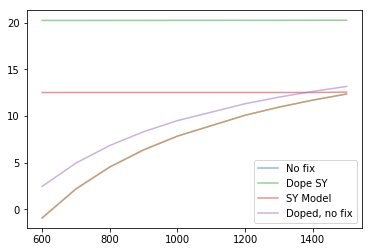

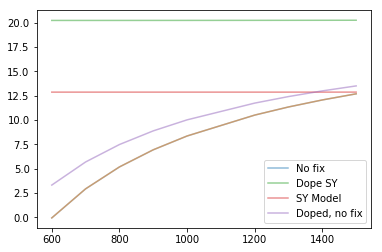

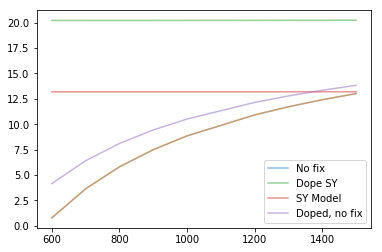

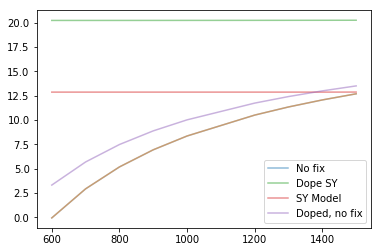

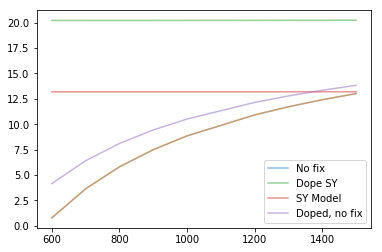

In [30]:
import timeout_decorator
 
@timeout_decorator.timeout(20)
def doStuff(xj):
    #for xj in tqdm(np.arange(0,1050,1)):
        res = []
        sy = []
        fabs = []
        freeze = []
        itscrazybutitmightjustwork = []
        for i in [1500,1400,1300,1200,1000,900,800,700,600]: 
                results = scpf.run_some_fermi(scpf.compile_defects(grid.iloc[xj].to_dict()),nelect=544, e_gap=5.9034, T=1500, spin_polarised=True)
                re2 = scpf.run_some_fermi(scpf.compile_defects(grid.iloc[xj].to_dict()),nelect=544, e_gap=5.9034, T=i, spin_polarised=True)
                #print(results)
                for_frozen = {k : v for k,v in results.items() if k == 'v_Li_-1.0' or k == 'v_Li_0.0' or k == 'Li_i_1.0' or k == 'Li_i_0.0'}
                res.append(re2['c_e'])
                #print(for_frozen)
                formatt = [(str(k.split('_')[:-1]), v) for k,v in for_frozen.items()]
                z = defaultdict(list) 
                for k, v in formatt:
                     z[k].append(v)
                gg = {k:sum(v) for k,v in z.items()}
                regex = re.compile('[^a-zA-Z,]')
                x = {regex.sub('', k):v for k,v in gg.items()}
                regex = re.compile('[^a-zA-Z]')
                y = {regex.sub('_', k):v for k,v in x.items()}
                defex = []
                del results['Fermi_level']
                del results['c_h']
                del results['c_e']
                del results['v_Li_-1.0']
                del results['v_Li_0.0']
                del results['Li_i_1.0']
                del results['Li_i_0.0']
                for k,v in results.items():
                    if k is not 'Fermi_level' or k is not 'c_e' or k is not 'c_h':
                        d = [k.split('_')[0]+'_'+k.split('_')[1] + ' ' + k.split('_')[-1] + ' ' + str(v)]
                        defex.append(d)
                please = run_some_chg_car_fermi(scpf.compile_defects(grid.iloc[xj].to_dict()),nelect=544, e_gap=5.9034, temperature=i, spin_polarised=True)
                jeez = run_some_SY_fermi(scpf.compile_defects(grid.iloc[xj].to_dict()),nelect=544, e_gap=5.9034, temperature=i, spin_polarised=True, fixed_defects=y, fixed_charge_states=defex)
                defex.append(['dopant 2 1e+20'])
                frz = run_some_SY_fermi(scpf.compile_defects(grid.iloc[xj].to_dict()),nelect=544, e_gap=5.9034, temperature=i, spin_polarised=True, fixed_defects=y, fixed_charge_states=defex)
                freeze.append(frz['c_e'])
                sleaze = run_some_SY_fermi(scpf.compile_defects(grid.iloc[xj].to_dict()),nelect=544, e_gap=5.9034, temperature=i, spin_polarised=True, fixed_defects=None, fixed_charge_states=defex)
                fabs.append(sleaze['c_e'])
                itscrazybutitmightjustwork.append(please['c_e'])  
                sy.append(jeez['c_e'])
                #print(itscrazybutitmightjustwork)         
        plt.plot([1500,1400,1300,1200,1000,900,800,700,600],np.log10(itscrazybutitmightjustwork),alpha=0.5,label='No fix')
        plt.plot([1500,1400,1300,1200,1000,900,800,700,600],np.log10(res), alpha=0.5)
        plt.plot([1500,1400,1300,1200,1000,900,800,700,600],np.log10(freeze), alpha=0.5,label='Dope SY')
        plt.plot([1500,1400,1300,1200,1000,900,800,700,600],np.log10(sy),  alpha=0.5,label='SY Model')
        plt.plot([1500,1400,1300,1200,1000,900,800,700,600],np.log10(fabs),alpha=0.5,label='Doped, no fix')
        plt.legend()
        plt.show()
        
for data in a:
    try:
        doStuff(data)
    except:
        print('TD')
        continue


Volume of cell: 1056.622886347127 A^3
Found spin polarised system...
Number of electrons in system: 544
Energy gap of system: 5.904 eV
Temperature: 1500.0 K
Number of defect species: 14
Reading spin-polarised DOS


/home/alex/anaconda3/lib/python3.6/site-packages/scipy/optimize/_minimize.py:763: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)
/mnt/c/Users/Alex/Materials_work/new_fermi/py-sc-fermi/py_sc_fermi/defect_charge_state.py:79: RuntimeWarning: overflow encountered in exp
  return self.degeneracy * np.exp(expfac)
/home/alex/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1762: RuntimeWarning: invalid value encountered in double_scalars
  p = (xf - fulc) * q - (xf - nfc) * r
/home/alex/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1763: RuntimeWarning: invalid value encountered in double_scalars
  q = 2.0 * (q - r)
/mnt/c/Users/Alex/Materials_work/new_fermi/py-sc-fermi/py_sc_fermi/dos.py:86: RuntimeWarning: overflow encountered in exp
  return dos / (1.0 + np.exp((e_fermi - edos)/kT))
/mnt/c/Users/Alex/Materials_work/new_fermi/py-sc-fermi/py_

Volume of cell: 1056.622886347127 A^3
Found spin polarised system...
Number of electrons in system: 544
Energy gap of system: 5.904 eV
Temperature: 1500.0 K
Number of defect species: 14
Reading spin-polarised DOS
Volume of cell: 1056.622886347127 A^3
Found spin polarised system...
Number of electrons in system: 544
Energy gap of system: 5.904 eV
Temperature: 1500.0 K
Number of defect species: 14
Reading spin-polarised DOS


/home/alex/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1760: RuntimeWarning: invalid value encountered in double_scalars
  r = (xf - nfc) * (fx - ffulc)
/home/alex/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1761: RuntimeWarning: invalid value encountered in double_scalars
  q = (xf - fulc) * (fx - fnfc)
/mnt/c/Users/Alex/Materials_work/new_fermi/py-sc-fermi/py_sc_fermi/defect_charge_state.py:79: RuntimeWarning: overflow encountered in double_scalars
  return self.degeneracy * np.exp(expfac)


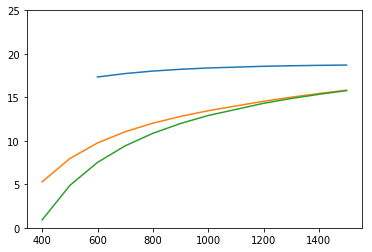

In [14]:
from py_sc_fermi.defect_charge_state import DefectChargeState, FrozenDefectChargeState
from py_sc_fermi.defect_system import DefectSystem
from py_sc_fermi.defect_species import DefectSpecies
from py_sc_fermi.inputs import inputs_from_files, read_input_data
from itertools import product
from scipy.constants import physical_constants
from scipy.constants import k
from tqdm import tqdm_notebook as tqdm
from vasppy.calculation import *
#from math import exp, erfc
from pymatgen.io.vasp import Outcar
import numpy as np
import sc_pyper_functions as scpf
import auto_functions as af
import matplotlib.pyplot as plt
import yaml
import pandas as pd


with open('automator_config.yaml', 'r') as stream: # get defect information from .yaml config
    try:                                           
        defect_params = yaml.safe_load(stream)     # return as a dict called defect_params
    except yaml.YAMLError as exc:
        print(exc)       


defects = af.import_calculations_from_file('defects.yaml')         # read in raw vasp data as vasppy calculation objects.
elements = af.import_calculations_from_file('elements.yaml')       # and give them intuitive names
llzo = af.import_calculations_from_file('interest.yaml')           #
ex_grid = (pd.read_csv('ex_grid.dat', skiprows=10, sep='\s+'))     # read in chemical potential grids as outputted by cplap 
grid = (pd.read_csv('grid.dat', skiprows=10, sep='\s+'))           # with both a larger grid and a smaller grid

def make_all_defects(config_dict,chem_pots):
    """
    Take defect data and return py_sc_fermi friendly defect objects.
    """
    defs = []
    for k,v in config_dict['defects'].items():
        label = [i for i in config_dict['defects'][k][1:]]
        to_calcs = [defects[i] for i in label]
        out = af.make_defect(to_calcs, elements, llzo['LLZO'], delta_mu=chem_pots, corr=config_dict['iccs'], sites=1)
        out._nsites = config_dict['defects'][out.name][0]
        defs.append(out)
    return defs


# Define necessary physical constants

kb_e = physical_constants['Boltzmann constant in eV/K'][0]
j_to_ev = 1/physical_constants['electron volt-joule relationship'][0]
S_0 = 205 * j_to_ev / physical_constants['Avogadro constant'][0]
Cp = (7/2)*kb_e

def dependance(P,T):
    """

    This function gives dependance of mu_O(T,P)
    args: P = pressure (float)
          T = temperature (float)

    returning:
          mu_O(T,P) (float)

    assuming oxygen is an ideal gas

    """

    chem_pot = 0.5 * ( (Cp * (T - 298))
                      - T * ( (S_0 + (Cp * np.log(T/298)) + (kb_e * np.log((0.21/P)) ) ) ))
    return chem_pot   

a=[]
temperature = np.arange(1200, 1400, 100)
pressure = np.logspace(-1, -10, num=20)
in_conds = product(pressure,temperature)
for i in tqdm(in_conds):
    mu_o = dependance(i[0], i[1])    # calculate oxygen chemical potential based of temperature and pressure 
    for j in range(grid.shape[0]):
        if round(mu_o,1) == round(grid['mu_O'][j],1):
            a.append(j)
bjq = set(a)

def sgc_electrons(temperatures,chemical_potentials,unitcell_filename='unitcell.dat',totdos_filename='totdos.dat',input_fermi_filename='input_fermi_cont.dat'):
    ### set paramters ###
    compilied_defects = make_all_defects(defect_params,chemical_potentials)
    inputs = inputs_from_files(unitcell_filename=unitcell_filename, input_fermi_filename=input_fermi_filename, totdos_filename=totdos_filename)
    defect_system_reference = DefectSystem(defect_species=compilied_defects,volume=inputs['volume'],dos=inputs['dos'],temperature=temperatures[-1], spin_pol=2)
    fixed_charge_states = defect_system_reference.to_dict(decomposed=True)
    all_frozen_charge_states = {}
    sgc_electrons = []
    sgc_holes = []
    ### fix defects based on reference defect system ###
    compilied_defects = make_all_defects(defect_params,chemical_potentials)
    for d in compilied_defects:
                frozen_charge_states = {}
                for i in d.charge_states:
                    c = fixed_charge_states[d.name][str(i)]
                    frozen_charge_state = FrozenDefectChargeState(charge=i, concentration=c/1e24 * defect_system_reference.volume) # 
                    frozen_charge_states.update({i : frozen_charge_state})
                all_frozen_charge_states.update({d.name:frozen_charge_states})
    for x in compilied_defects:
                x._charge_states = None
                x._charge_states = all_frozen_charge_states[x.name]
    compilied_defects[1] = af.make_defect([defects['v_Li'],defects['v_Li_-']], elements, llzo['LLZO'], delta_mu=chemical_potentials, corr=defect_params['iccs'], sites=3)
    compilied_defects[2] = af.make_defect([defects['Li_i'],defects['Li_i_+']], elements, llzo['LLZO'], delta_mu=chemical_potentials, corr=defect_params['iccs'], sites=1)
    for t in temperatures:
        defect_system_sgc = DefectSystem(defect_species=compilied_defects,volume=inputs['volume'],dos=inputs['dos'],temperature=t,spin_pol=2)
        defect_system_sgc.defect_species_by_name('v_Li').fix_concentration(defect_system_reference.to_dict()['v_Li'] * defect_system_reference.volume / 1e24) #  
        defect_system_sgc.defect_species_by_name('Li_i').fix_concentration(defect_system_reference.to_dict()['Li_i'] * defect_system_reference.volume / 1e24) #  
        defect_concs_sgc = defect_system_sgc.to_dict()
        sgc_elec = defect_concs_sgc['n0']
        sgc_hole = defect_concs_sgc['p0']
        sgc_electrons.append(sgc_elec)
        sgc_holes.append(sgc_hole)
        #defect_system_sgc.report()
    return sgc_electrons

def c_electrons(temperatures,chemical_potentials,unitcell_filename='unitcell.dat',totdos_filename='totdos.dat',input_fermi_filename='input_fermi_cont.dat'):
    ### set paramters ###
    compilied_defects = make_all_defects(defect_params,chemical_potentials)
    inputs = inputs_from_files(unitcell_filename=unitcell_filename, input_fermi_filename=input_fermi_filename, totdos_filename=totdos_filename)
    defect_system_reference = DefectSystem(defect_species=compilied_defects,volume=inputs['volume'],dos=inputs['dos'],temperature=temperatures[-1], spin_pol=2)
    fixed_charge_states = defect_system_reference.to_dict(decomposed=True)
    all_frozen_charge_states = {}
    c_electrons = []
    c_holes = []  
    ### fix defects based on reference defect system ###
    compilied_defects = make_all_defects(defect_params,chemical_potentials)
    for d in compilied_defects:
                frozen_charge_states = {}
                for i in d.charge_states:
                    c = fixed_charge_states[d.name][str(i)]
                    frozen_charge_state = FrozenDefectChargeState(charge=i, concentration=c/1e24 * defect_system_reference.volume) # 
                    frozen_charge_states.update({i : frozen_charge_state})
                all_frozen_charge_states.update({d.name:frozen_charge_states})
    for x in compilied_defects:
                x._charge_states = None
                x._charge_states = all_frozen_charge_states[x.name]
    compilied_defects[1] = af.make_defect([defects['v_Li'],defects['v_Li_-']], elements, llzo['LLZO'], delta_mu=chemical_potentials, corr=defect_params['iccs'], sites=3)
    compilied_defects[2] = af.make_defect([defects['Li_i'],defects['Li_i_+']], elements, llzo['LLZO'], delta_mu=chemical_potentials, corr=defect_params['iccs'], sites=1)
    for t in temperatures:
        defect_system_c = DefectSystem(defect_species=compilied_defects,volume=inputs['volume'],dos=inputs['dos'],temperature=t,spin_pol=2)
        fermi = defect_system_c.get_constrained_sc_fermi({'v_Li': +1, 'Li_i': -1}, -2.1312254035009536e+16)
        a,b = defect_system_c.dos.carrier_concentrations(fermi, kb_e*t)     
        c_electrons.append(b * 1e24 / defect_system_reference.volume)
        c_holes.append(a * 1e24 / defect_system_reference.volume)
    #    defect_system_c.report()
    return c_electrons

def electrons(temperatures,chemical_potentials,unitcell_filename='unitcell.dat',totdos_filename='totdos.dat',input_fermi_filename='input_fermi_cont.dat'):
    ### set paramters ###
    compilied_defects = make_all_defects(defect_params,chemical_potentials)
    inputs = inputs_from_files(unitcell_filename=unitcell_filename, input_fermi_filename=input_fermi_filename, totdos_filename=totdos_filename)
    defect_system_reference = DefectSystem(defect_species=compilied_defects,volume=inputs['volume'],dos=inputs['dos'],temperature=temperatures[-1], spin_pol=2)
    fixed_charge_states = defect_system_reference.to_dict(decomposed=True)
    all_frozen_charge_states = {}
    electrons = []
    holes = []  
    ### fix defects based on reference defect system ###
    compilied_defects = make_all_defects(defect_params,chemical_potentials)
    for t in temperatures:
        defect_system = DefectSystem(defect_species=compilied_defects,volume=inputs['volume'],dos=inputs['dos'],temperature=t,spin_pol=2)   
        electrons.append(defect_system.to_dict()['n0'])
    #    defect_system.report()
    return electrons

#for i in range(len(grid)):
plt.ylim(0,25)
plt.plot([400,500,600,700,800,900,1000,1200,1300,1400,1500],np.log10(sgc_electrons([400,500,600,700,800,900,1000,1200,1300,1400,1500],grid.iloc[0].to_dict())))
plt.plot([400,500,600,700,800,900,1000,1200,1300,1400,1500],np.log10(c_electrons([400,500,600,700,800,900,1000,1200,1300,1400,1500],grid.iloc[0].to_dict())))
plt.plot([400,500,600,700,800,900,1000,1200,1300,1400,1500],np.log10(electrons([400,500,600,700,800,900,1000,1200,1300,1400,1500],grid.iloc[0].to_dict())))
plt.show()

In [7]:
defect_system_high_t.to_dict()['v_Li'] / 1e24 * defect_system_high_t.volume  - defect_system_high_t.to_dict()['Li_i'] / 1e24 * defect_system_high_t.volume

NameError: name 'defect_system_high_t' is not defined

In [18]:
defect_system_c

NameError: name 'defect_system_c' is not defined

Volume of cell: 1056.622886347127 A^3
Found spin polarised system...
Number of electrons in system: 544
Energy gap of system: 5.904 eV
Temperature: 1500.0 K
Number of defect species: 14
Reading spin-polarised DOS
{2: q=+2, [c]=3.315255281793358e-07, 1: q=+1, [c]=0.00022639635081783923, 0: q=+0, [c]=4.687414032395892e-05}
{0: q=+0, [c]=1.2021702373898317e-14, -1: q=-1, [c]=0.037586589285117745}
{0: q=+0, [c]=2.786091813973528e-06, 1: q=+1, [c]=0.02982415385971398}
{0: q=+0, [c]=1.3223978036141848e-23, -1: q=-1, [c]=2.419041047658554e-28}
{-3: q=-3, [c]=1.561449030316904e-11}
{-4: q=-4, [c]=1.9946776988290444e-19}
{0: q=+0, [c]=2.3324894111458166e-20, 1: q=+1, [c]=5.644407789395529e-18, 2: q=+2, [c]=1.3862803887039326e-10, 3: q=+3, [c]=2.445461025081419e-09, 4: q=+4, [c]=1.234072299968917e-09}
{0: q=+0, [c]=8.47779227726243e-12, 1: q=+1, [c]=6.208634210488934e-10, 2: q=+2, [c]=0.0001484427225460945, 3: q=+3, [c]=3.1080249077150695e-64}
{0: q=+0, [c]=2.6836703975684767e-08, 1: q=+1, [c]=8

/home/alex/anaconda3/lib/python3.6/site-packages/scipy/optimize/_minimize.py:763: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)
/mnt/c/Users/Alex/Materials_work/new_fermi/py-sc-fermi/py_sc_fermi/defect_charge_state.py:79: RuntimeWarning: overflow encountered in exp
  return self.degeneracy * np.exp(expfac)
/home/alex/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1762: RuntimeWarning: invalid value encountered in double_scalars
  p = (xf - fulc) * q - (xf - nfc) * r
/home/alex/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1763: RuntimeWarning: invalid value encountered in double_scalars
  q = 2.0 * (q - r)


SC Fermi level :      4.296848714484756  (eV)

Concentrations:
n (electrons)  : 5898928816625680.0 cm^-3
p (holes)      : 36557532.22676709 cm^-3
v_O            : 2.5894008190037053e+17 cm^-3
v_Li           : 3.5572378528898232e+19 cm^-3
Li_i           : 2.822855755314394e+19 cm^-3
O_i            : 0.01251555319416209 cm^-3
v_La           : 14777732427.384834 cm^-3
v_Zr           : 188.77858151145523 cm^-3
Zr_i           : 3613551648521.164 cm^-3
Zr_Li_tet      : 1.4048848826004032e+17 cm^-3
Zr_Li          : 2.3281622697089623e+18 cm^-3
Zr_La          : 1.7051011370145258e+17 cm^-3
La_Zr          : 16312598411201.346 cm^-3
Li_La          : 255870310256127.2 cm^-3
Li_Zr          : 1762719410065.6504 cm^-3
La_Li          : 26265729256996.57 cm^-3

Breakdown of concentrations for each defect charge state:
---------------------------------------------------------
v_O        : Charge Concentration(cm^-3) Total
           :  2  3.137596e+14          0.12 
           :  1  2.142641e+17       

<BarContainer object of 1 artists>

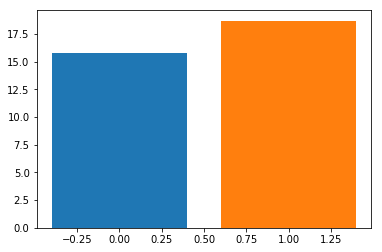

In [46]:
compilied_defects = make_all_defects(defect_params,grid.iloc[0].to_dict())
inputs = inputs_from_files(unitcell_filename='unitcell.dat', input_fermi_filename='input_fermi_cont.dat', totdos_filename='totdos.dat')
defect_system_reference = DefectSystem(defect_species=compilied_defects,volume=inputs['volume'],dos=inputs['dos'],temperature=1500, spin_pol=2)
fixed_charge_states = defect_system_reference.to_dict(decomposed=True)
### fix defects based on reference defect system ###
compilied_defects = make_all_defects(defect_params,grid.iloc[0].to_dict())
for d in compilied_defects:
    d.write_fixed_concentration()
            frozen_charge_states = {}
            for i in d.charge_states:
                c = fixed_charge_states[d.name][str(i)]
                frozen_charge_state = FrozenDefectChargeState(charge=i, concentration=c/1e24 * defect_system_reference.volume) # 
                frozen_charge_states.update({i : frozen_charge_state})
            all_frozen_charge_states.update({d.name:frozen_charge_states})
for x in compilied_defects:
            x._charge_states = None
            x._charge_states = all_frozen_charge_states[x.name]
for i in compilied_defects:
    print(i.charge_states)
compilied_defects[1] = af.make_defect([defects['v_Li'],defects['v_Li_-']], elements, llzo['LLZO'], delta_mu=grid.iloc[0].to_dict(), corr=defect_params['iccs'], sites=3)
compilied_defects[2] = af.make_defect([defects['Li_i'],defects['Li_i_+']], elements, llzo['LLZO'], delta_mu=grid.iloc[0].to_dict(), corr=defect_params['iccs'], sites=1)

defect_system_sgc = DefectSystem(defect_species=compilied_defects,volume=inputs['volume'],dos=inputs['dos'],temperature=1500,spin_pol=2)
defect_system_sgc.defect_species_by_name('v_Li').fix_concentration(defect_system_reference.to_dict()['v_Li'] / 1e24 * defect_system_reference.volume) #  
defect_system_sgc.defect_species_by_name('Li_i').fix_concentration(defect_system_reference.to_dict()['Li_i'] / 1e24 * defect_system_reference.volume) #  
defect_concs_sgc = defect_system_sgc.to_dict()

defect_system_sgc.report()
defect_system_reference.report()

plt.bar(0,np.log10(defect_system_reference.to_dict()['n0']))
plt.bar(1,np.log10(defect_concs_sgc['n0']))

In [27]:
defect_system_reference.to_dict()['v_Li']

/home/alex/anaconda3/lib/python3.6/site-packages/scipy/optimize/_minimize.py:763: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)
/mnt/c/Users/Alex/Materials_work/new_fermi/py-sc-fermi/py_sc_fermi/defect_charge_state.py:79: RuntimeWarning: overflow encountered in exp
  return self.degeneracy * np.exp(expfac)
/home/alex/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1762: RuntimeWarning: invalid value encountered in double_scalars
  p = (xf - fulc) * q - (xf - nfc) * r
/home/alex/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1763: RuntimeWarning: invalid value encountered in double_scalars
  q = 2.0 * (q - r)


3.5572378538071572e+19

In [33]:
import pprint
pprint.pprint(defect_system_reference.to_dict(decomposed=True))
pprint.pprint(defect_system_sgc.to_dict(decomposed=True))

{'Fermi Energy': 4.296848714518089,
 'La_Li': {'0': 136750192.56202668,
           '1': 19285038212.64631,
           '2': 26246307455049.645},
 'La_Zr': {'-1': 16312598414212.547, '0': 1195.5052203063617},
 'Li_La': {'-1': 428.23691121981545,
           '-2': 255870310387665.72,
           '0': 1.723310232372683e-11},
 'Li_Zr': {'-1': 7.579970201720836e-10,
           '-2': 193.09005863984078,
           '-3': 1762719411236.2874,
           '0': 2.8373732566569754e-23},
 'Li_i': {'0': 2636789198845942.5, '1': 2.8225920756666257e+19},
 'O_i': {'-1': 2.2894081501693304e-07, '0': 0.012515324253347131},
 'Zr_La': {'0': 1485564844190272.0, '1': 1.690245488136744e+17},
 'Zr_Li': {'0': 25398563974383.043,
           '1': 7593466471317908.0,
           '2': 2.8129817838960598e+17,
           '3': 2.039245224559367e+18},
 'Zr_Li_tet': {'0': 8023479698.202622,
               '1': 587592251759.0863,
               '2': 1.404878925718512e+17,
               '3': 2.941470365515068e-43},
 'Zr_i': {

/home/alex/anaconda3/lib/python3.6/site-packages/scipy/optimize/_minimize.py:763: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)
/mnt/c/Users/Alex/Materials_work/new_fermi/py-sc-fermi/py_sc_fermi/defect_charge_state.py:79: RuntimeWarning: overflow encountered in exp
  return self.degeneracy * np.exp(expfac)
/home/alex/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1762: RuntimeWarning: invalid value encountered in double_scalars
  p = (xf - fulc) * q - (xf - nfc) * r
/home/alex/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1763: RuntimeWarning: invalid value encountered in double_scalars
  q = 2.0 * (q - r)


In [28]:
from auto_functions import *
from py_sc_fermi.inputs import inputs_from_files
from pandas import DataFrame as df
import pandas as pd
from itertools import product
from tqdm import tqdm
import numpy as np
from scipy.constants import physical_constants

grid = (pd.read_csv('grid.dat', skiprows=10, sep='\s+'))  # 'grid' refers to a stability region divded into a grid of approximatley 80 points
ex_grid = (pd.read_csv('ex_grid.dat', skiprows=10, sep='\s+'))

def dependance(P,T):
    """
    
    This function gives dependance of mu_O(T,P)
    args: P = pressure (float)
          T = temperature (float)
          
    returning:
          mu_O(T,P) (float)
          
    assuming oxygen is an ideal gas
    
    """
    
    chem_pot = 0.5 * ( (Cp * (T - 298))
                      - T * ( (S_0 + (Cp * np.log(T/298)) + (kb_e * np.log((0.21/P)) ) ) ))  
    return chem_pot          

kb_e = physical_constants['Boltzmann constant in eV/K'][0]
j_to_ev = 1/physical_constants['electron volt-joule relationship'][0]
S_0 = 205 * j_to_ev / physical_constants['Avogadro constant'][0]
Cp = (7/2)*kb_e

temperature = np.arange(800, 1600, 100)
pressure = np.logspace(-1, -10, num=10)
in_conds = product(pressure,temperature)

unitcell_filename = 'unitcell.dat'
totdos_filename = 'totdos.dat'
input_fermi_filename = 'input-fermi.dat'

# inputs = inputs_from_files(unitcell_filename=unitcell_filename, 
#                            input_fermi_filename=input_fermi_filename, 
#                            totdos_filename=totdos_filename)

# out_undoped=[]
# for i in tqdm(in_conds):
#         mu_o = dependance(i[0], i[1])    # calculate oxygen chemical potential based of temperature and pressure 
#         for j in range(ex_grid.shape[0]):
#             if round(mu_o,1) == round(ex_grid['mu_O'][j],1):
#                     b = make_all_defects(a,ex_grid.iloc[j].to_dict())

defect_system = DefectSystem( defect_species=b,
                                volume=inputs['volume'],
                                dos=inputs['dos'],
                                temperature=300)
#         out_undoped.append(defect_system.to_dict())
defect_system.report()
#defect_system.get_constrained_sc_fermi({'v_Li': +1, 'Li_i': -1}, constraint)
print(defect_system.to_dict()['v_Li'] - defect_system.to_dict()['Li_i'])
print(constraint)
ahhh = defect_system.get_constrained_sc_fermi({'v_Li': +1, 'Li_i': -1}, constraint)
defect_system.write_inputs('input-fermi-frozen.dat')

TypeError: __init__() missing 1 required positional argument: 'spin_pol'

In [7]:
5.020959929938431e-24 * 1e24 / defect_system_sunghyun.volume

NameError: name 'defect_system_sunghyun' is not defined

In [22]:
ficharg = False
fixconch = False
namefn = defect_system.defect_species_names
chargefn = [-1.0, 1.0]
concfn = [0.19e19, 0.5e20]
if 0 in chargefn:
    checkfixchg = True
else:
    checkfixchg = False
for n,q,c  in zip( namefn, chargefn, concfn ):
    print(c)
    c = c * defect_system.volume / 1e24

    if n in defect_system.defect_species_names:     
        defect_system.defect_species_by_name(n).charge_states[q] = frozen_charge_state
    else:
        ds = DefectSpecies(name=n, nsites=1, charge_states=[frozen_charge_state])
        defect_system.defect_species.append(ds)

1.9e+18
5e+19


In [35]:
for i,j in zip(all_frozen_charge_states,b):
    print(type(all_frozen_charge_states[j.name]))

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


In [11]:
defect_system.defect_species_by_name('v_O').(all_frozen_charge_states['v_O'])

SyntaxError: invalid syntax (<ipython-input-11-3e7d8ae30852>, line 1)

In [41]:
b[0].charge_states

{0: q=+0, e=3.430977650000065, deg=1,
 1: q=+1, e=-0.9798363610594906, deg=2,
 2: q=+2, e=-4.522686024237847, deg=1}

In [17]:
b[1] = make_defect([defects['v_Li'],defects['v_Li_-']], elements, interest['LLZO'], delta_mu=ex_grid.iloc[5497].to_dict(), corr=a['iccs'], sites=3)
b[2] = make_defect([defects['Li_i'],defects['Li_i_+']], elements, interest['LLZO'], delta_mu=ex_grid.iloc[5497].to_dict(), corr=a['iccs'], sites=1)

In [20]:
b

[
 v_O, nsites=3
   q=+2, [c]=1.95371445701975e-08
   q=+1, [c]=1.0964709087204011e-08
   q=+0, [c]=1.865711908943459e-12, 
 v_Li, nsites=3
   q=+0, e=3.4713573800000104, deg=2
   q=-1, e=3.959671988940586, deg=1, 
 Li_i, nsites=1
   q=+0, e=2.6462461100000683, deg=2
   q=+1, e=-2.939530639755103, deg=1, 
 O_i, nsites=1
   q=+0, [c]=1.1074639464890854e-16
   q=-1, [c]=1.664923532741314e-24, 
 v_La, nsites=2
   q=-3, [c]=1.180868301691534e-10, 
 v_Zr, nsites=1
   q=-4, [c]=1.6651526320547301e-16, 
 Zr_i, nsites=1
   q=+0, [c]=1.2745963527569528e-35
   q=+1, [c]=3.75307978035854e-30
   q=+2, [c]=1.1215972007106742e-19
   q=+3, [c]=2.4074817641882648e-15
   q=+4, [c]=1.4782888055452145e-12, 
 Zr_Li_tet, nsites=1
   q=+0, [c]=5.020959929938431e-24
   q=+1, [c]=4.474211205277478e-19
   q=+2, [c]=1.301654553278397e-10
   q=+3, [c]=3.316177320445699e-67, 
 Zr_Li, nsites=2
   q=+0, [c]=7.946999107003572e-21
   q=+1, [c]=2.891016063533735e-15
   q=+2, [c]=1.3031480792641396e-10
   q=+3, [c]=1.1

NameError: name 'constraint' is not defined

In [41]:
from py_sc_fermi.constants import kboltz
inputs['dos'].carrier_concentrations(ahhh, kboltz*400)[1] * 1e24 / defect_system.volume

/mnt/c/Users/Alex/Materials_work/new_fermi/py-sc-fermi/py_sc_fermi/dos.py:86: RuntimeWarning: overflow encountered in exp
  return dos / (1.0 + np.exp((e_fermi - edos)/kT))


39848935.686796546

In [5]:
5.861142806132946e-08 * 1e24 / defect_system_high_t.volume

55470526730644.88

In [6]:
fix

{'Fermi Energy': 3.378588096089299,
 'La_Li': {'0': 5.747064021154197e-21,
  '1': 9.86177284287399e-16,
  '2': 1.6331237901679048e-09},
 'La_Zr': {'-1': 9.513073380553605e-07, '0': 8.483314762254493e-14},
 'Li_La': {'-1': 9.34952685497451e-15,
  '-2': 4.591018354229147e-06,
  '0': 4.578101368278683e-25},
 'Li_Zr': {'-1': 1.1113916382339392e-21,
  '-2': 2.3267147265357027e-13,
  '-3': 1.7456212047369914e-06,
  '0': 5.062120745490645e-32},
 'Li_i': {'0': 2.5706587612672673e-09, '1': 0.033483707538704825},
 'O_i': {'-1': 1.66492361297815e-24, '0': 1.1074639464890854e-16},
 'Zr_La': {'0': 2.337316556244727e-11, '1': 3.2358777799524536e-06},
 'Zr_Li': {'0': 1.5893998214007144e-20,
  '1': 5.7820318484168274e-15,
  '2': 2.606295907320423e-10,
  '3': 2.2990195196549705e-06},
 'Zr_Li_tet': {'0': 5.020959929938431e-24,
  '1': 4.474210989654041e-19,
  '2': 1.3016544278184224e-10,
  '3': 3.316176841001065e-67},
 'Zr_i': {'0': 1.2745963527569528e-35,
  '1': 3.753079599488231e-30,
  '2': 1.121597092

In [14]:
defect_system_high_t.to_dict()['v_Li']

/home/alex/anaconda3/lib/python3.6/site-packages/scipy/optimize/_minimize.py:763: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)
/mnt/c/Users/Alex/Materials_work/new_fermi/py-sc-fermi/py_sc_fermi/defect_charge_state.py:79: RuntimeWarning: overflow encountered in exp
  return self.degeneracy * np.exp(expfac)
/home/alex/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1762: RuntimeWarning: invalid value encountered in double_scalars
  p = (xf - fulc) * q - (xf - nfc) * r
/home/alex/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1763: RuntimeWarning: invalid value encountered in double_scalars
  q = 2.0 * (q - r)


2.998661772957925e+40

In [83]:
a = (defect_system_high_t.to_dict()['Li_i'] - defect_system_high_t.to_dict()['v_Li'])

/home/alex/anaconda3/lib/python3.6/site-packages/scipy/optimize/_minimize.py:763: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)
/mnt/c/Users/Alex/Materials_work/new_fermi/py-sc-fermi/py_sc_fermi/defect_charge_state.py:79: RuntimeWarning: overflow encountered in exp
  return self.degeneracy * np.exp(expfac)
/home/alex/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1762: RuntimeWarning: invalid value encountered in double_scalars
  p = (xf - fulc) * q - (xf - nfc) * r
/home/alex/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1763: RuntimeWarning: invalid value encountered in double_scalars
  q = 2.0 * (q - r)


In [3]:
defect_concs_compare = scpf.run_some_fermi(scpf.compile_defects(grid.iloc[grid_to_test].to_dict()), # read in chemical potentials from stablity region
                             nelect=544,                                                  # number of electrons in calculation
                             e_gap=5.9034,                                                # bandgap magnitude
                             T=1500,                                                      # temperature
                             spin_polarised=True)                                         # is calculation spin polarised?
wrapped_compare = (wrap_concs(defect_concs_compare))

In [4]:
wrapped_compare

{'La_Li': 94671386367.39128,
 'La_Zr': 4233408360413232.0,
 'Li_La': 1.1859114794824876e+16,
 'Li_Zr': 8.480912329258266e+16,
 'Li_i': 3.1777176180312183e+19,
 'O_i': 0.012564764756395239,
 'Zr_La': 337299891404540.0,
 'Zr_Li': 68829695744806.5,
 'Zr_Li_tet': 11884129677605.121,
 'Zr_i': 298475394.4667359,
 'v_La': 1217217180159.0,
 'v_Li': 3.1511607592042484e+19,
 'v_O': 9.659997017969051e+16,
 'v_Zr': 8070677.757042}

In [182]:
y

{'Li_i': 3.1777176180312183e+19, 'v_Li': 3.1511607592042484e+19}

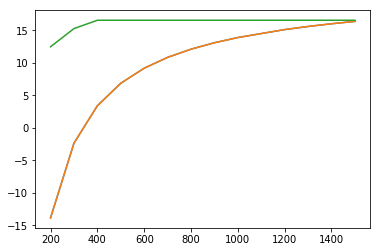

In [213]:
plt.plot([1500,1400,1300,1200,1000,900,800,700,600,500,400,300,200],np.log10(itscrazybutitmightjustwork))
plt.plot([1500,1400,1300,1200,1000,900,800,700,600,500,400,300,200],np.log10(res))
plt.plot([1500,1400,1300,1200,1000,900,800,700,600,500,400,300,200],np.log10(sy))

In [205]:
for k,v in results.items():
    if k is not 'c_h':
        print(v)

4.419095411679e+16
5.239016637977e+16
18849683130510.0
2484069.786905
3.151160759204e+19
1217217180159.0
8070677.757042
1.207695858218e+16
3.176509922173e+19
0.1416650272633
8.423280896616
50831615.56638
220324864.4109
27318905.92451
0.01256382938687
9.353695252387e-07
4233408360337000.0
76232.19548307
11648625066340.0
325651266338200.0
35586885294.5
2614212146042.0
23795103637640.0
42384793075830.0
11241999.82214
202291115.299
11883916144490.0
6.113713607346e-48
2.025049553565e-20
2.201743636893e-06
2282649.514273
8.48091232903e+16
4.822094405232e-11
4876.816417821
1.185911479482e+16
8145250.670378
282238947.4809
94381002169.24
4.4782795436159
2.406380396263e+16


In [174]:
defex = []
for k,v in results.items():
    if k != any(['v_Li_-1.0','v_Li_0.0','Li_i_1.0','Li_i_0.0']):
        d = [k.split('_')[0]+'_'+k.split('_')[1] + ' ' + k.split('_')[-1] + ' ' + str(v)]
        defex.append(d)
defex

[['v_O 0.0 4.419095411679e+16'],
 ['v_O 1.0 5.239016637977e+16'],
 ['v_O 2.0 18849683130510.0'],
 ['v_Li 0.0 2484069.786905'],
 ['v_Li -1.0 3.151160759204e+19'],
 ['v_La -3.0 1217217180159.0'],
 ['v_Zr -4.0 8070677.757042'],
 ['Li_i 0.0 1.207695858218e+16'],
 ['Li_i 1.0 3.176509922173e+19'],
 ['Zr_i 0.0 0.1416650272633'],
 ['Zr_i 1.0 8.423280896616'],
 ['Zr_i 2.0 50831615.56638'],
 ['Zr_i 3.0 220324864.4109'],
 ['Zr_i 4.0 27318905.92451'],
 ['O_i 0.0 0.01256382938687'],
 ['O_i -1.0 9.353695252387e-07'],
 ['La_Zr -1.0 4233408360337000.0'],
 ['La_Zr 0.0 76232.19548307'],
 ['Zr_La 0.0 11648625066340.0'],
 ['Zr_La 1.0 325651266338200.0'],
 ['Zr_Li 0.0 35586885294.5'],
 ['Zr_Li 1.0 2614212146042.0'],
 ['Zr_Li 2.0 23795103637640.0'],
 ['Zr_Li 3.0 42384793075830.0'],
 ['Zr_Li 0.0 11241999.82214'],
 ['Zr_Li 1.0 202291115.299'],
 ['Zr_Li 2.0 11883916144490.0'],
 ['Zr_Li 3.0 6.113713607346e-48'],
 ['Li_Zr 0.0 2.025049553565e-20'],
 ['Li_Zr -1.0 2.201743636893e-06'],
 ['Li_Zr -2.0 2282649.514273'

In [126]:
run_some_SY_fermi(scpf.compile_defects(grid.iloc[grid_to_test].to_dict()),                            
                             nelect=544,                                                  # number of electrons in calculation
                             e_gap=5.9034,                                                # bandgap magnitude
                             temperature=1500,
                             fixed_charge_states = [['B',1,1e14]],
                             spin_polarised=True)

{'Fermi_level': 4.4782797450528,
 'La_Li_0.0': 8145250.670378,
 'La_Li_1.0': 282238507.6447,
 'La_Li_2.0': 94380708006.11,
 'La_Zr_-1.0': 4233414957616000.0,
 'La_Zr_0.0': 76232.19548307,
 'Li_La_-1.0': 4876.824017777,
 'Li_La_-2.0': 1.185915175698e+16,
 'Li_La_0.0': 4.822094405232e-11,
 'Li_Zr_-1.0': 2.201747068056e-06,
 'Li_Zr_-2.0': 2282656.628771,
 'Li_Zr_-3.0': 8.480951978664e+16,
 'Li_Zr_0.0': 2.025049553565e-20,
 'Li_i_0.0': 1.207695858218e+16,
 'Li_i_1.0': 3.176504971956e+19,
 'O_i_-1.0': 9.353709829042e-07,
 'O_i_0.0': 0.01256382938687,
 'Zr_La_0.0': 11648625066340.0,
 'Zr_La_1.0': 325650758849000.0,
 'Zr_Li_0.0': 35586885294.5,
 'Zr_Li_1.0': 2614208072100.0,
 'Zr_Li_2.0': 23795029473960.0,
 'Zr_Li_3.0': 42384594921010.0,
 'Zr_Li_tet_0.0': 11241999.82214,
 'Zr_Li_tet_1.0': 202290800.0522,
 'Zr_Li_tet_2.0': 11883879105150.0,
 'Zr_Li_tet_3.0': 6.113685024882e-48,
 'Zr_i_0.0': 0.1416650272633,
 'Zr_i_1.0': 8.423267769925,
 'Zr_i_2.0': 50831457.13632,
 'Zr_i_3.0': 220323834.3614,


In [74]:
print(formatt)

[("['v', 'O']", 4.419095411679e+16), ("['v', 'O']", 5.239016637977e+16), ("['v', 'O']", 18849683130510.0), ("['v', 'Li']", 2484069.786905), ("['v', 'Li']", 3.151160759204e+19), ("['v', 'La']", 1217217180159.0), ("['v', 'Zr']", 8070677.757042), ("['Li', 'i']", 1.207695858218e+16), ("['Li', 'i']", 3.176509922173e+19), ("['Zr', 'i']", 0.1416650272633), ("['Zr', 'i']", 8.423280896616), ("['Zr', 'i']", 50831615.56638), ("['Zr', 'i']", 220324864.4109), ("['Zr', 'i']", 27318905.92451), ("['O', 'i']", 0.01256382938687), ("['O', 'i']", 9.353695252387e-07), ("['La', 'Zr']", 4233408360337000.0), ("['La', 'Zr']", 76232.19548307), ("['Zr', 'La']", 11648625066340.0), ("['Zr', 'La']", 325651266338200.0), ("['Zr', 'Li']", 35586885294.5), ("['Zr', 'Li']", 2614212146042.0), ("['Zr', 'Li']", 23795103637640.0), ("['Zr', 'Li']", 42384793075830.0), ("['Zr', 'Li', 'tet']", 11241999.82214), ("['Zr', 'Li', 'tet']", 202291115.299), ("['Zr', 'Li', 'tet']", 11883916144490.0), ("['Zr', 'Li', 'tet']", 6.11371360734

In [4]:
from tqdm import tqdm_notebook as tqdm
import re
from vasppy.calculation import *
import subprocess
import pandas as pd
from scipy.stats import linregress
from scipy.constants import physical_constants
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import itertools
from math import exp, erfc
from pymatgen.io.vasp import Outcar


# Define necessary physical constants

kb_e = physical_constants['Boltzmann constant in eV/K'][0]
j_to_ev = 1/physical_constants['electron volt-joule relationship'][0]
S_0 = 205 * j_to_ev / physical_constants['Avogadro constant'][0]
Cp = (7/2)*kb_e

def dependance(P,T):
    """

    This function gives dependance of mu_O(T,P)
    args: P = pressure (float)
          T = temperature (float)

    returning:
          mu_O(T,P) (float)

    assuming oxygen is an ideal gas

    """

    chem_pot = 0.5 * ( (Cp * (T - 298))
                      - T * ( (S_0 + (Cp * np.log(T/298)) + (kb_e * np.log((0.21/P)) ) ) ))
    return chem_pot   

a=[]
temperature = np.arange(1200, 1400, 100)
pressure = np.logspace(-1, -10, num=20)
in_conds = itertools.product(pressure,temperature)
for i in tqdm(in_conds):
    mu_o = dependance(i[0], i[1])    # calculate oxygen chemical potential based of temperature and pressure 
    for j in range(grid.shape[0]):
        if round(mu_o,1) == round(grid['mu_O'][j],1):
            a.append(j)

In [6]:
bjq= list(set(a))

In [16]:
bjq

[31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51]

In [10]:
len(in_conds)

TypeError: object of type 'itertools.product' has no len()